## Explain the loss for an NHANES model

Moving from release cycles 1-5 (train) to release cycles 6-8 (test).

This constitutes a significant increase in model loss.

**Question of interest: Can we identify features that contribute to this increase in loss**?

In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from xgboost import XGBClassifier

import matplotlib.pylab as plt
import numpy as np

import matplotlib
import pickle
import shap
import os

from deepshap.data import load_nhanes_new

# Name of experiment we are running
exp_name = "cycle_shift"

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_new()

# Train or load model
mpath = "models/{}_xgb.p".format(exp_name)
if not os.path.exists(mpath):
    model = XGBClassifier()
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=10, verbose=False)
    pickle.dump(model, open(mpath,"wb"))
else:
    model = pickle.load(open(mpath,"rb"))
    
# Evaluate model performance
print("Train ROC AUC ", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
print("Test ROC AUC  ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print("Train loss    ", log_loss(y_train, model.predict_proba(X_train)[:,1]))
print("Test loss     ", log_loss(y_test, model.predict_proba(X_test)[:,1]))

Train ROC AUC  0.9882752748310369
Test ROC AUC   0.8681190191906044
Train loss     0.08771404129969228
Test loss      0.26650387368177847


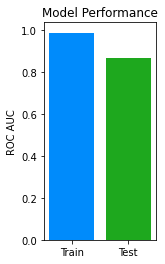

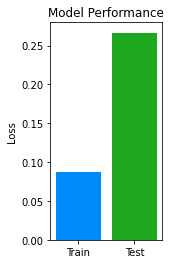

In [2]:
plt.rcParams['figure.figsize'] = 2,4

plt.bar(range(2), [roc_auc_score(y_train, model.predict_proba(X_train)[:,1]), 
                   roc_auc_score(y_test, model.predict_proba(X_test)[:,1])], color=["#008bfb","#1ea81e"])
plt.title("Model Performance")
plt.ylabel("ROC AUC")
plt.xticks(range(2),["Train", "Test"])
plt.savefig("fig/{}_performance_roc.pdf".format(exp_name))
plt.show()

plt.bar(range(2), [log_loss(y_train, model.predict_proba(X_train)[:,1]), 
                   log_loss(y_test, model.predict_proba(X_test)[:,1])], color=["#008bfb","#1ea81e"])
plt.title("Model Performance")
plt.ylabel("Loss")
plt.xticks(range(2),["Train", "Test"])
plt.savefig("fig/{}_performance_loss.pdf".format(exp_name))
plt.show()

### Load/compute attributions

In [5]:
###############################
### Get output attributions ###
###############################
train_attr_path = "attr/{}_train_attr.npy".format(exp_name)
test_attr_path  = "attr/{}_test_attr.npy".format(exp_name)

np.random.seed(102190)
rand_inds = np.random.choice(range(X_train.shape[0]), 1000, replace=False)
reference = X_train.iloc[rand_inds]

explainer = shap.TreeExplainer(model, data=reference)
if not (os.path.exists(train_attr_path) and os.path.exists(test_attr_path)):
    train_attr = explainer.shap_values(X_train)
    test_attr  = explainer.shap_values(X_test)
    
    np.save(train_attr_path, train_attr)
    np.save(test_attr_path, test_attr)
else:
    train_attr = np.load(train_attr_path)
    test_attr  = np.load(test_attr_path)

#############################
### Get loss attributions ###
#############################
train_loss_attr_path = "attr/{}_train_loss_attr.npy".format(exp_name)
test_loss_attr_path  = "attr/{}_test_loss_attr.npy".format(exp_name)

loss_explainer = shap.TreeExplainer(model, data=reference, model_output="log_loss")
if not (os.path.exists(train_loss_attr_path) and os.path.exists(test_loss_attr_path)):
    train_loss_attr = loss_explainer.shap_values(X_train, y_train)
    test_loss_attr  = loss_explainer.shap_values(X_test, y_test)
    
    np.save(train_loss_attr_path, train_loss_attr)
    np.save(test_loss_attr_path, test_loss_attr)
else:
    train_loss_attr = np.load(train_loss_attr_path)
    test_loss_attr  = np.load(test_loss_attr_path)

### Plot attributions

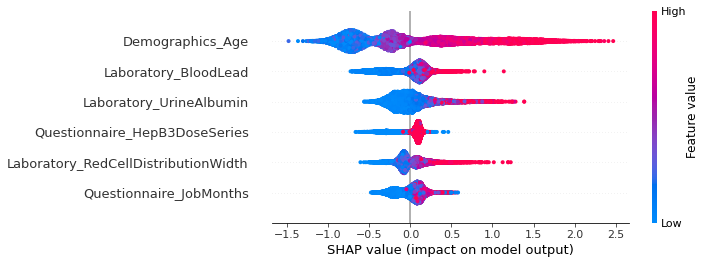

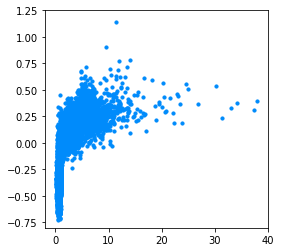

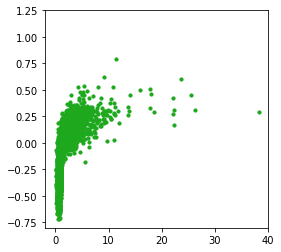

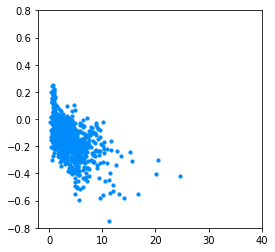

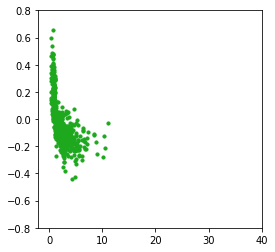

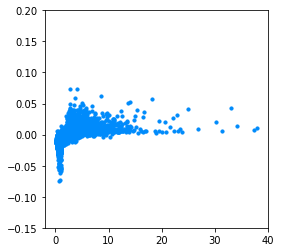

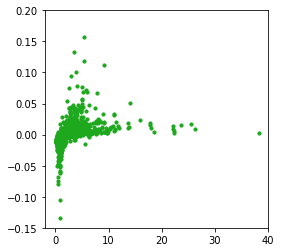

In [6]:
import matplotlib.pylab as plt
import shap

def dep_plot(attr, featvals, title, is_save=False, xlim=None, ylim=None, color=None):
    if not color: color = "#008bfb"
    col_ind = list(featvals.columns).index(col_name)
    plt.scatter(featvals[col_name], attr[:,col_ind], s=10, color=color, rasterized=True)
    plt.xlim(xlim)
    plt.ylim(ylim)
#     shap.dependence_plot(col_name, attr, featvals, interaction_index=None, 
#                          show=False, xmin=0, xmax=400)
#     shap.dependence_plot(col_name, attr, featvals, interaction_index=int_name, show=False)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(4, 4)
#     plt.title(title)
    
    if is_save:
        fig_name = "fig/{}_{}_{}.pdf".format(exp_name, title, col_name)
        plt.savefig(fig_name)
        
    plt.show()
    
is_save = True

# col_name = "Demographics_Age"
col_name = "Laboratory_BloodLead"
int_name = "Demographics_ReleaseCycle"

###########################
### Output explanations ###
###########################
shap.summary_plot(train_attr, X_train, max_display=6)
# shap.summary_plot(test_attr, X_test, max_display=10)
xlim = [-2,40]
ylim = [-.8,1.25]
dep_plot(train_attr, X_train, "model_output_train", is_save=is_save, xlim=xlim, ylim=ylim, color="#008bfb")
dep_plot(test_attr, X_test, "model_output_test", is_save=is_save, xlim=xlim, ylim=ylim, color="#1ea81e")

#########################
### Loss explanations ###
#########################
# Attributions for positive samples
ylim = [-.8,.8]
dep_plot(train_loss_attr[y_train == 1], X_train[y_train == 1],
         "model_loss_train_y1", is_save=is_save, xlim=xlim, ylim=ylim, color="#008bfb")
dep_plot(test_loss_attr[y_test == 1], X_test[y_test == 1], 
         "model_loss_test_y1", is_save=is_save, xlim=xlim, ylim=ylim, color="#1ea81e")

# Attributions for negative samples
ylim = [-.15,.2]
dep_plot(train_loss_attr[y_train == 0], X_train[y_train == 0], 
         "model_loss_train_y0", is_save=is_save, xlim=xlim, ylim=ylim, color="#008bfb")
dep_plot(test_loss_attr[y_test == 0], X_test[y_test == 0], 
         "model_loss_test_y0", is_save=is_save, xlim=xlim, ylim=ylim, color="#1ea81e")

Samples that are very badly misclassified in terms of bloodlead or age

**How to verify that this is the case??**  Ablate those specific features by the mean and see how the loss changes. (Kind of a first order approach)

In [ ]:
def log_loss_per_sample(ytrue, ypred):
    """
    log_loss computation that does not fail if all labels are the same
    """
    return((-(ytrue*np.log(ypred)+(1-ytrue)*np.log(1-ypred))))

def log_loss_safe(ytrue, ypred):
    """
    log_loss computation that does not fail if all labels are the same
    """
    return(log_loss_per_sample(ytrue, ypred).mean())

# Get top indices in terms of attribution
col_ind = list(X_train.columns).index(col_name)
num_samp = 10
top_train_y1_inds = (-train_loss_attr[y_train == 1][:, col_ind]).argsort()[:num_samp]
top_test_y1_inds  = (-test_loss_attr[y_test == 1][:, col_ind]).argsort()[:num_samp]
print("Top {} Train Y=1 Loss Attributions".format(col_name), 
      train_loss_attr[y_train == 1][:, col_ind][top_train_y1_inds][:num_samp])
print("Top {} Test Y=1 Loss Attributions".format(col_name), 
      test_loss_attr[y_test == 1][:, col_ind][top_test_y1_inds][:num_samp])

top_train_y0_inds = (-train_loss_attr[y_train == 0][:, col_ind]).argsort()[:num_samp]
top_test_y0_inds  = (-test_loss_attr[y_test == 0][:, col_ind]).argsort()[:num_samp]

In [ ]:
import pandas as pd
np.random.seed(102190)
rand_inds = np.random.choice(range(X_train.shape[0]), 1000, replace=False)
reference = X_train.iloc[rand_inds]

def ablate_once(y_curr, x_curr):
    """
    Ablate a single feature once
    """
    loss_old   = log_loss_safe(y_curr, model.predict_proba(x_curr)[:,1])
    x_curr[col_name] = reference[col_name].mean()
    loss_new   = log_loss_safe(y_curr, model.predict_proba(x_curr)[:,1])
    delta_loss = loss_new-loss_old
    print("Loss Old      : ", loss_old)
    print("Loss New      : ", loss_new)
    print("Loss New - Old: ", delta_loss)
    return(delta_loss)
    
print("#"*20)
print("Ablate Train Y=1")
print("#"*20)
train_delta_y1 = ablate_once(y_train.loc[y_train==1].iloc[top_train_y1_inds], 
                             X_train.loc[y_train==1].iloc[top_train_y1_inds])

print("#"*20)
print("Ablate Test Y=1")
print("#"*20)
test_delta_y1 = ablate_once(y_test.loc[y_test==1].iloc[top_test_y1_inds], 
                            X_test.loc[y_test==1].iloc[top_test_y1_inds])

print("\n")
print("#"*20)
print("Ablate Train Y=0")
print("#"*20)
train_delta_y0 = ablate_once(y_train.loc[y_train==0].iloc[top_train_y0_inds], 
                             X_train.loc[y_train==0].iloc[top_train_y0_inds])

print("#"*20)
print("Ablate Test Y=0")
print("#"*20)
test_delta_y0 = ablate_once(y_test.loc[y_test==0].iloc[top_test_y0_inds], 
                            X_test.loc[y_test==0].iloc[top_test_y0_inds])

In [ ]:
plt.rcParams['figure.figsize'] = 2,4

plt.bar(range(2), [train_delta_y1, test_delta_y1])
plt.title("Y=1")
plt.ylabel("Difference in Loss")
plt.xticks(range(2),["Train", "Test"])
plt.savefig("fig/{}_ablate_top10_y1.pdf".format(exp_name))
plt.show()

plt.bar(range(2), [train_delta_y0, test_delta_y0])
plt.title("Y=0")
plt.ylabel("Difference in Loss")
plt.xticks(range(2),["Train", "Test"])
plt.savefig("fig/{}_ablate_top10_y0.pdf".format(exp_name))
plt.show()

**Conclusion**: Ablating the most positive loss attributions for blood lead has an extremely large effect on loss for Test and less so for Train.  This only measures marginal effect but it shows that our findings are real.

### Check the distributions of the points that hurt the loss

In [ ]:
X_train.loc[y_train==1].iloc[top_train_y1_inds]
X_test.loc[y_test==1].iloc[top_test_y1_inds]
X_train.loc[y_train==0].iloc[top_train_y0_inds]
X_test.loc[y_test==0].iloc[top_test_y0_inds]

In [ ]:
X_train.loc[y_train==1].iloc[top_train_y1_inds][col_name]

In [ ]:
model.predict_proba((X_train.loc[y_train==1].iloc[top_train_y1_inds]))

In [ ]:
plt.hist(X_train.loc[y_train==1][col_name], 40)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                train_attr[y_train==1][top_train_y1_inds][0:1,:],
                X_train.loc[y_train==1].iloc[top_train_y1_inds].iloc[0:1,:])

In [ ]:
X_test.loc[y_test==1].iloc[top_test_y1_inds][col_name]

In [ ]:
top_train_y1_inds = (-train_loss_attr[y_train == 1][:, col_ind]).argsort()[:num_samp]
top_test_y1_inds  = (-test_loss_attr[y_test == 1][:, col_ind]).argsort()[:num_samp]

In [ ]:
sorted(test_attr[y_test==1][:,col_ind][test_attr[y_test==1][:,col_ind].argsort()[:num_samp]])

In [ ]:
sorted(test_attr[y_test==1][top_test_y1_inds][:,col_ind])

In [ ]:
shap.summary_plot(train_attr[y_train==1][top_train_y1_inds], X_train.loc[y_train==1].iloc[top_train_y1_inds], max_display=10)
shap.summary_plot(train_attr, X_train, max_display=6)

shap.summary_plot(train_loss_attr[y_train==1][top_train_y1_inds], X_train.loc[y_train==1].iloc[top_train_y1_inds], max_display=10)
shap.summary_plot(train_loss_attr, X_train, max_display=6)

In [ ]:
model.predict_proba(X_test.loc[y_test==0].iloc[top_test_y0_inds])

In [ ]:
model.predict_proba(X_train.loc[y_train==1].iloc[top_train_y1_inds])

In [ ]:
model.predict_proba(X_test.loc[y_test==1].iloc[top_test_y1_inds])

### Maybe the reason is that these samples are very misclassified and the train samples are just misclassified in terms of blood lead

In [ ]:
shap.summary_plot(test_attr[y_test==1][top_test_y1_inds], X_test.loc[y_test==1].iloc[top_test_y1_inds], max_display=10)
shap.summary_plot(test_attr, X_test, max_display=6)

shap.summary_plot(test_loss_attr[y_test==1][top_test_y1_inds], X_test.loc[y_test==1].iloc[top_test_y1_inds], max_display=10)
shap.summary_plot(test_loss_attr, X_test, max_display=6)

In [ ]:
plt.hist(X_test.loc[y_test==1][col_name], 40)